In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark.sql import functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/09/30 14:19:20 WARN Utils: Your hostname, AryansLaptop resolves to a loopback address: 127.0.1.1; using 172.25.9.137 instead (on interface eth0)
22/09/30 14:19:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/30 14:19:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Profit per transaction

In [2]:
finaldf = spark.read.parquet("../data/curated/finaldf.parquet/")
finaldf = finaldf.withColumn('profit', round(finaldf.dollar_value * (finaldf.take_rate / 100), 2))
finaldf.limit(5)

22/09/30 14:19:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%,profit
2021-08-21,94729574738,16982,4821,23684,156.3091245999424,407ce815-54e1-4ae...,QLD,Female,Scelerisque Corpo...,computer programm...,4.51,b,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,7.05
2022-04-24,45572698303,16982,4821,23684,115.38672513864692,72160f0d-06c5-432...,QLD,Female,Libero Proin Corp.,shoe shops,3.30,b,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,3.81
2021-08-21,34695415993,16982,4821,23684,35.730567249104645,d4524ef6-1f75-4f2...,QLD,Female,Ultrices Vivamus ...,"cable, satellite,...",6.02,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,2.15
2022-04-24,67400260923,16982,4821,23684,73.85811747094266,7acb9a9f-3ef6-4d4...,QLD,Female,Eleifend PC,computer programm...,5.97,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,4.41
2021-08-19,86578477987,16982,4821,23684,41.45540307953735,e8be544a-a311-432...,QLD,Female,Leo In Consulting,"watch, clock, and...",6.43,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1,2.67


In [3]:
baseline = finaldf.groupBy("merchant_abn").agg(
    round(sum("profit"),2).alias("profit"),
).orderBy("profit", ascending = False)
baseline.limit(5)

merchant_abn,profit
32361057556,539219.85
48534649627,535362.31
86578477987,531231.65
45629217853,506903.56
96680767841,500075.01


In [4]:
from pyspark.sql.functions import *

modeldf = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf = modeldf.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))
modeldf = modeldf.withColumn("day", date_format(col("order_datetime"), "dd").cast("long"))

for field in ("postcode","take_rate"):
    modeldf = modeldf.withColumn(
        field,
        col(field).cast('double')
    )

modeldf = modeldf.drop("order_datetime","order_id","company_name","consumer_fraud_%","merchant_fraud_%")

modeldf.limit(5)

merchant_abn,user_id,postcode,consumer_id,dollar_value,state,gender,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,profit,year,month,day
94729574738,16982,4821.0,23684,156.3091245999424,QLD,Female,computer programm...,4.51,b,3128,468,271,707,947,735,1972,44,45102,50599,7.05,2021,8,21
45572698303,16982,4821.0,23684,115.38672513864692,QLD,Female,shoe shops,3.3,b,3128,468,271,707,947,735,1972,44,45102,50599,3.81,2022,4,24
34695415993,16982,4821.0,23684,35.730567249104645,QLD,Female,"cable, satellite,...",6.02,a,3128,468,271,707,947,735,1972,44,45102,50599,2.15,2021,8,21
67400260923,16982,4821.0,23684,73.85811747094266,QLD,Female,computer programm...,5.97,a,3128,468,271,707,947,735,1972,44,45102,50599,4.41,2022,4,24
86578477987,16982,4821.0,23684,41.45540307953735,QLD,Female,"watch, clock, and...",6.43,a,3128,468,271,707,947,735,1972,44,45102,50599,2.67,2021,8,19


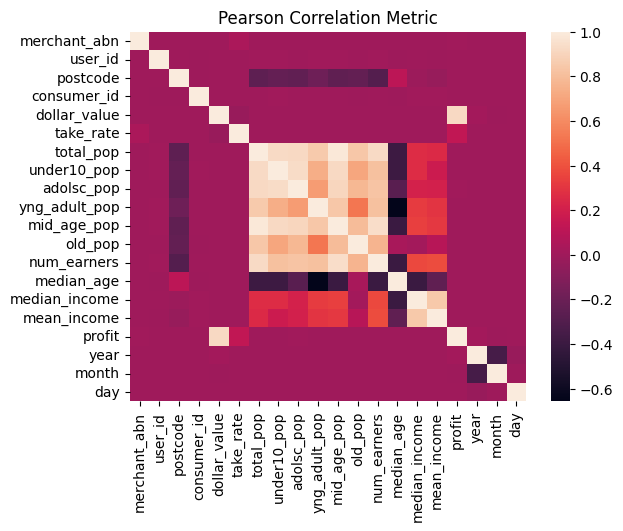

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

SAMPLE_SIZE = 0.05

df = modeldf.sample(SAMPLE_SIZE, seed=0).toPandas()

sns.heatmap(df.corr())
plt.title('Pearson Correlation Metric')
plt.show()

In [6]:
from scipy.stats import f_oneway

print(f_oneway(df["year"],df["profit"]))
print(f_oneway(df["month"],df["profit"]))
print(f_oneway(df["day"],df["profit"]))
print(f_oneway(df["merchant_abn"],df["profit"]))
print(f_oneway(df["user_id"],df["profit"]))
print(f_oneway(df["postcode"],df["profit"]))
print(f_oneway(df["total_pop"],df["profit"]))
print(f_oneway(df["num_earners"],df["profit"]))
print(f_oneway(df["median_age"],df["profit"]))
print(f_oneway(df["median_income"],df["profit"]))
print(f_oneway(df["mean_income"],df["profit"]))

F_onewayResult(statistic=8729564623.710001, pvalue=0.0)
F_onewayResult(statistic=98.40718901997504, pvalue=3.413368451612462e-23)
F_onewayResult(statistic=142822.45206062015, pvalue=0.0)
F_onewayResult(statistic=2878146.735800838, pvalue=0.0)
F_onewayResult(statistic=1761579.6960201345, pvalue=0.0)
F_onewayResult(statistic=4293009.032238776, pvalue=0.0)
F_onewayResult(statistic=1499234.0511832563, pvalue=0.0)
F_onewayResult(statistic=1347712.4969764336, pvalue=0.0)
F_onewayResult(statistic=2879336.2688626973, pvalue=0.0)
F_onewayResult(statistic=17287541.950882357, pvalue=0.0)
F_onewayResult(statistic=8209200.342476988, pvalue=0.0)
